In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:

import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random
from model import segnet
from generator import cityscapes_labels
from generator import utils



/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
!nvidia-smi

Sat Jan 20 18:31:27 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.111                Driver Version: 384.111                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 970     Off  | 00000000:01:00.0  On |                  N/A |
| 42%   34C    P8    17W / 250W |    236MiB /  4034MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [6]:

#target_height, target_width = 360, 480
target_height, target_width = 360, 648
labels = cityscapes_labels.labels
n_classes = len(labels)
batch_size = 2
epochs = 10

dataset_path = '/home/xmlyna06/data/gta/'

images_path = os.path.join(dataset_path, 'images/')
labels_path = os.path.join(dataset_path, 'labels/')

model = segnet.get_model(target_height, target_width, n_classes)

model.load_weights('weights/weights__100-0.93.hdf5')

model.summary()

model.compile(
    loss="categorical_crossentropy",
    optimizer='sgd',
    metrics=["categorical_accuracy"]
)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_3 (Layer)              (None, 360, 648, 3)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 360, 648, 64)      1792      
_________________________________________________________________
batch_normalization_17 (Batc (None, 360, 648, 64)      256       
_________________________________________________________________
activation_11 (Activation)   (None, 360, 648, 64)      0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 180, 324, 64)      0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 180, 324, 128)     73856     
_________________________________________________________________
batch_normalization_18 (Batc (None, 180, 324, 128)     512       
__________

In [7]:
image = cv2.imread(images_path + '00008.png')
print(image.shape)

from generator import data_generator

norm = data_generator.SimpleSegmentationGenerator.normalize(image, (target_height,target_width))

for_prediction = np.array([norm])
prediction = model.predict_proba(for_prediction, batch_size, verbose=1)


(1052, 1914, 3)
1/1 [==============================] - 6s 6s/step


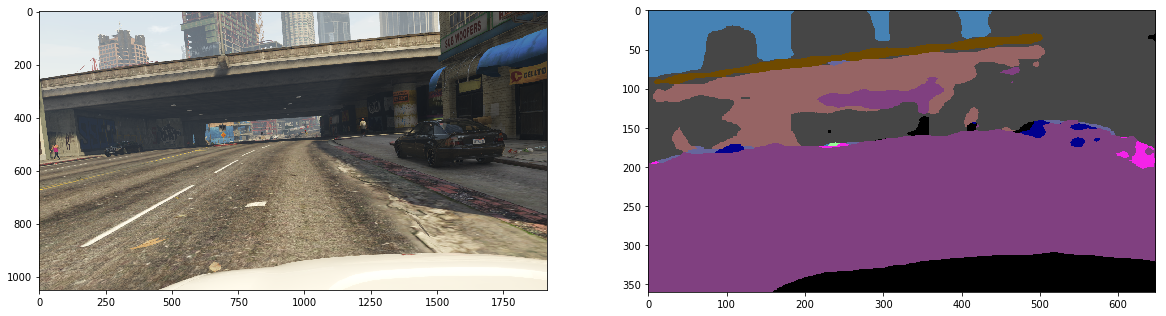

In [8]:
from generator import cityscapes_labels


class_scores = prediction.reshape((target_height, target_width, n_classes))
class_image = np.argmax(class_scores, axis=2)

colored_class_image = utils.class_image_to_image(class_image, cityscapes_labels.trainId2label)  # there should be trainid2label


#viz_segmentation = vizualize(prediction, target_width, target_height, n_classes)
f, arr= plt.subplots(1,2)

f.set_size_inches(20,20)

predicting_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
arr[0].imshow(predicting_image)
arr[1].imshow(colored_class_image)